## **Northeastern SMILE Lab - Recognizing Faces in the Wild**

## Background

The SMILE Lab at Northeastern focuses on the frontier research of applied machine learning, social media analytics, human-computer interaction, and high-level image and video understanding. Their research is driven by the explosion of diverse multimedia from the Internet, including both personal and publicly available photos and videos. They start by treating fundamental theory from learning algorithms as the soul of machine intelligence and arm it with visual perception.

Northeastern University has been developing an automatic kinship classifier since 2010. However, the widespread adoption of this technology has been hindered by two primary factors:

- Data Limitations: Existing image databases for kinship recognition are insufficient in size and diversity to accurately represent global familial relationships.

- Model Complexity: The complex interplay of genetic and environmental factors influencing facial features necessitates a more advanced model than traditional computer vision algorithms, which are typically designed for higher-level tasks like facial recognition or object classification.

## Objective

Using the provided competition data, the following model predicts the probability of two individuals being related (1) based solely on a pair of facial images. 

## **Step 1**: Download the official Kaggle competition (FIW) data.

***Before executing the following cells***, please review section 7 of the rules: https://www.kaggle.com/competitions/recognizing-faces-in-the-wild/rules#7-competition-data. 

Note that all usages of FIW data should cite the following papers:

*Joseph P Robinson, Ming Shao, Hongfu Liu, Yue Wu, Timothy Gillis, and Yun Fu. "Visual Kinship Recognition of Families In the Wild" IEEE TPAMI Special Edition: Computational Face (2018).
Joseph P Robinson, Ming Shao, Handong Zhao, Yue Wu, Timothy Gillis, Yun Fu. "Recognizing Families In the Wild (RFIW): Data Challenge Workshop in conjunction with ACM MM 2017," ACM Multimedia Conference: Workshop on RFIW (2017).
Shuyang Wang, Joseph P Robinson, and Yun Fu. “Kinship Verification on Families in the Wild with Marginalized Denoising Metric Learning,” in IEEE Automatic Face and Gesture Recognition (2017).
Joseph P Robinson, Ming Shao, Yue Wu, and Yun Fu. “Families In the Wild (FIW): large-scale kinship image database and benchmarks." in ACM on Multimedia Conference (2016).*

In [1]:
download_path = '_provided-data' # Intermediate directories are excluded recursively via. .gitignore (i.e., '_*/').
competition = 'recognizing-faces-in-the-wild' # Hosted here: https://www.kaggle.com/c/recognizing-faces-in-the-wild


In [2]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

os.makedirs(download_path, exist_ok=True)
print('Downloading ' + competition + ' provided data into ' + download_path)
api = KaggleApi()
api.authenticate()
api.competition_download_files(competition, path = download_path)


In [3]:
import os
import zipfile

def unzip(zip_path):
    dest_dir = '_' + os.path.basename(zip_path)[:-4]
    if (not os.path.exists(dest_dir)):
        os.makedirs(dest_dir, exist_ok=True)
        print('Decompressing ' + zip_path + ' into ' + dest_dir)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dest_dir)
    print(dest_dir + '/')
    print(os.listdir(dest_dir)[:10])
    return dest_dir

print('Decompressing ' + competition + ' provided data:')
dataset_path = unzip(download_path + '/' + competition + '.zip')
training_image_path = unzip(dataset_path + '/train-faces.zip')
testing_image_path = unzip(dataset_path + '/test-faces.zip')


Decompressing recognizing-faces-in-the-wild provided data:
_recognizing-faces-in-the-wild/
['README.md', 'sample_submission.csv', 'test-faces.zip', 'test-private-faces.zip', 'test-private-labels.zip', 'test-private-lists.zip', 'test-public-faces.zip', 'test-public-lists.zip', 'test.zip', 'train-faces.zip']
_train-faces/
['F0001', 'F0002', 'F0003', 'F0004', 'F0005', 'F0006', 'F0007', 'F0008', 'F0011', 'F0012']
_test-faces/
['22AYVUUOY5.jpg', '22EHSQ3J67.jpg', '23CPGCRQYL.jpg', '23JHLHHVQ7.jpg', '23NVWX5EJY.jpg', '23VRLQQU2Z.jpg', '23WR6OWN6N.jpg', '24GVLNJKZE.jpg', '24JEM3FJTP.jpg', '24JQ7IM5RN.jpg']


## **Step 2**: Load and clean the labeled dataset.
The _train_relationships.csv_ encodes (ground truth) kinship relations between pairs of people. 


In [4]:
from collections import defaultdict
import glob
import pandas

relations_csv_path = dataset_path + '/train_relationships.csv'
print('Loading ' + relations_csv_path)
relations_df = pandas.read_csv(relations_csv_path, delimiter=',', header='infer')

# Create a dictionary to lookup image files for each member
family_dict = defaultdict(list)
for family in glob.glob(training_image_path + '*'):
    for member in glob.glob(family + '/*'):
        for image_path in glob.glob(member + '/*'):
            member = member.split('\\')[-1]
            image_path = image_path.split('\\')[-1]
            family_dict[member].append(image_path)

print('Images found for members of ' + str(len(family_dict.items())) + ' total families.')
for key, value in list(family_dict.items())[:5]:
    print(str(key) + ': ' + str(value) + ',')
    
# Remove entries which do not exist in the training set
print('The original ground truth relations data contains ' + str(len(relations_df)) + ' pairs.')
print(relations_df)

print('Checking for missing relation image data.')
fam_keys = family_dict.keys()
missing_relations_list = []
for index, row in relations_df.iterrows():
    split1 = row.p1.split('/')
    split2 = row.p2.split('/')
    p1fam = split1[0]
    p2fam = split2[0]
    if (p1fam not in fam_keys or p2fam not in fam_keys):
        missing_relations_list.append(index)
        continue
    p1member = split1[1]
    p2member = split2[1]
    if (p1member not in family_dict[p1fam] or p2member not in family_dict[p2fam]):
        missing_relations_list.append(index)
        continue
    images1 = os.listdir(training_image_path + '/' + p1fam + '/' + p1member)
    images2 = os.listdir(training_image_path + '/' + p2fam + '/' + p2member)
    if (len(images1) == 0 or len(images2) == 0):
        missing_relations_list.append(index)
        continue
if (missing_relations_list.count):
    relations_df = relations_df.drop(missing_relations_list)
    print(str(len(missing_relations_list)) + ' pairs were removed due to missing data.')
    print(relations_df)
else:
    print('All relations were found to have valid image data.')


Loading _recognizing-faces-in-the-wild/train_relationships.csv
Images found for members of 786 total families.
F0001: ['MID1', 'MID2', 'MID3', 'MID4'],
F0002: ['MID1', 'MID2', 'MID3'],
F0003: ['MID1', 'MID2', 'MID3', 'MID4'],
F0004: ['MID1', 'MID2', 'MID3', 'MID4', 'MID5', 'MID6', 'MID7'],
F0005: ['MID1', 'MID2', 'MID3'],
The original ground truth relations data contains 3598 pairs.
              p1          p2
0     F0002/MID1  F0002/MID3
1     F0002/MID2  F0002/MID3
2     F0005/MID1  F0005/MID2
3     F0005/MID3  F0005/MID2
4     F0009/MID1  F0009/MID4
...          ...         ...
3593  F1000/MID5  F1000/MID8
3594  F1000/MID5  F1000/MID9
3595  F1000/MID6  F1000/MID9
3596  F1000/MID7  F1000/MID8
3597  F1000/MID7  F1000/MID9

[3598 rows x 2 columns]
Checking for missing relation image data.
1108 pairs were removed due to missing data.
              p1          p2
0     F0002/MID1  F0002/MID3
1     F0002/MID2  F0002/MID3
2     F0005/MID1  F0005/MID2
3     F0005/MID3  F0005/MID2
29    F00

## **Step 3**: Show a random selection of the relations.

               p1           p2
2069  F0601/MID20  F0601/MID42
2961   F0816/MID1   F0816/MID4
3028   F0825/MID5   F0825/MID2


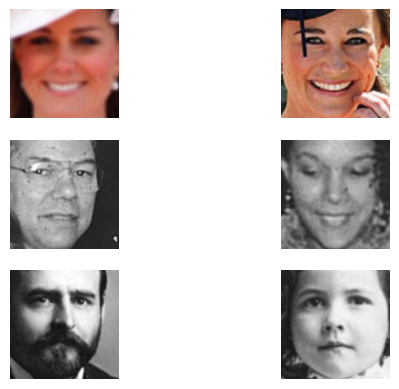

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
from random import choice

SAMPLE_COUNT = 3
samples = relations_df.sample(SAMPLE_COUNT)
print(samples)

f, ax = plt.subplots(SAMPLE_COUNT, 2)
for a in ax.flat:
    a.axis('off')
i = 0
for member in samples.values:
    img1 = training_image_path + '/' + member[0] + '/' \
        + choice(os.listdir(training_image_path + '/' + member[0]))
    img2 = training_image_path + '/' + member[1] + '/'  \
        + choice(os.listdir(training_image_path + '/' + member[1]))
    rgb1 = Image.open(img1)
    rgb2 = Image.open(img2)
    ax[i][0].imshow(rgb1)
    ax[i][1].imshow(rgb2)
    i = i + 1


## **Step 4**: Separate the relations data into training and testing portions.

In [16]:
import itertools
import random

# Create a list of all of the members in the relations data
members = []
for member in relations_df.values:
    if (member[0] not in members):
        members.append(member[0])
    if (member[1] not in members):
        members.append(member[1])
members.sort()
print(str(len(members)) + ' total members in the training set.')

# Create a list of the corresponding images
member_images = dict()
for member in members:
    set = os.listdir(training_image_path + '/' + member)
    if (len(set) > 0):
        image_set = []
        for image in set:
            image_set.append(member + '/' + image)
        member_images[member] = image_set

training_data_positives = []
# Add the related image pairs
for index, row in relations_df.iterrows():
    p1 = row.p1
    p2 = row.p2
    p1_images = list(member_images[p1])
    p2_images = list(member_images[p2])
    for image1, image2 in itertools.product(p1_images, p2_images):
        training_data_positives.append([image1, image2, 1.0])
print('Training data contains ' + str(len(training_data_positives)) + ' (positive) pairs.')

# Add the unrelated image pairs
training_data_negatives = []
index = 0
while index < len(training_data_positives):
    p1 = random.choice(members)
    p2 = random.choice(members)
    if (p1 == p2):
        continue # try again
    p1_images = list(member_images[p1])
    p2_images = list(member_images[p2])
    for image1, image2 in itertools.product(p1_images, p2_images):
        training_data_negatives.append([image1, image2, 0.0])
        index = index + 1
print('Training data contains ' + str(len(training_data_negatives)) + ' (negative) pairs.')

# Use a similar number of true positives and true negatives for trainings and testing
num_training_samples = 1000
if (num_training_samples > len(training_data_positives)):
    num_training_samples = len(training_data_positives)
training_data = random.sample(training_data_positives, num_training_samples)
training_data = training_data + random.sample(training_data_negatives, num_training_samples)
random.shuffle(training_data)
print('Training set contains ' + str(len(training_data)) + ' pairs.')
print(training_data[:10])

num_testing_samples = 500
if (num_testing_samples > len(training_data_positives)):
    num_testing_samples = len(training_data_positives)
testing_data = random.sample(training_data_positives, num_testing_samples)
testing_data = testing_data + random.sample(training_data_negatives, num_testing_samples)
random.shuffle(testing_data)
print('Testing set contains ' + str(len(testing_data)) + ' pairs.')
print(testing_data[:10])


1727 total members in the training set.
Training data contains 128578 (positive) pairs.
Training data contains 128836 (negative) pairs.
Training set contains 2000 pairs.
[['F0164/MID1/P01760_face2.jpg', 'F0164/MID3/P01761_face1.jpg', 1.0], ['F0601/MID6/P04415_face2.jpg', 'F0601/MID7/P06399_face3.jpg', 1.0], ['F0064/MID1/P00650_face1.jpg', 'F0064/MID2/P00642_face4.jpg', 1.0], ['F0168/MID4/P01805_face4.jpg', 'F0933/MID2/P09842_face1.jpg', 0.0], ['F0601/MID6/P11951_face7.jpg', 'F0601/MID7/P12011_face1.jpg', 1.0], ['F0425/MID1/P04484_face1.jpg', 'F0425/MID3/P11463_face1.jpg', 1.0], ['F0881/MID5/P09296_face1.jpg', 'F0746/MID2/P07814_face2.jpg', 0.0], ['F0601/MID2/P06396_face1.jpg', 'F0601/MID5/P06302_face2.jpg', 1.0], ['F0387/MID6/P04107_face1.jpg', 'F0215/MID3/P11496_face2.jpg', 0.0], ['F0882/MID1/P12352_face2.jpg', 'F0882/MID4/P12354_face2.jpg', 1.0]]
Testing set contains 1000 pairs.
[['F0813/MID2/P08594_face2.jpg', 'F0299/MID2/P03182_face2.jpg', 0.0], ['F0283/MID4/P03024_face3.jpg', 'F01

## **Step 5**: Train the model

In [7]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image

transform = transforms.Compose([
                                transforms.Resize((56,56)),
                                transforms.ToTensor(),
                                ])
    
class ImagePairDataset(Dataset):
    def __init__(self, data):
        self.image_pairs = [sublist[:-1] for sublist in data]
        self.labels = torch.tensor([sublist[-1] for sublist in data], dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img0 = Image.open('_train-faces/' + self.image_pairs[idx][0])
        img1 = Image.open('_train-faces/' + self.image_pairs[idx][1])
        img0 = transform(img0)
        img1 = transform(img1)
        return img0, img1, self.labels[idx]

dataset_tensor = ImagePairDataset(training_data)
print('The dataset_tensor contains ' + str(len(dataset_tensor)) + ' samples.')

# Create a data loader to iterate over the dataset_tensor in batches
batch_size = 32
dataloader = torch.utils.data.DataLoader(dataset_tensor, batch_size=batch_size)
print('The dataloader contains ' + str(len(dataloader)) + ' batches.')


The dataset_tensor contains 2000 samples.
The dataloader contains 63 batches.


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Convolutional layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(9216, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

# Hyperparameters
num_epochs = 50
learning_rate = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the network
model = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [9]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for i, (data1, data2, label) in enumerate(dataloader):
        data1, data2, label = data1.to(device), data2.to(device), label.to(device)
        optimizer.zero_grad()
        output1, output2 = model(data1, data2)
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data1.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'Epoch Loss: {epoch_loss:.4f}')

for epoch in range(num_epochs):
    train_loss = train(model, dataloader, criterion, optimizer, device)

print('Finished training.')


Epoch Loss: 1.2851
Epoch Loss: 1.1289
Epoch Loss: 1.1048
Epoch Loss: 1.0830
Epoch Loss: 1.0668
Epoch Loss: 1.0545
Epoch Loss: 1.0454
Epoch Loss: 1.0366
Epoch Loss: 1.0292
Epoch Loss: 1.0223
Epoch Loss: 1.0164
Epoch Loss: 1.0115
Epoch Loss: 1.0074
Epoch Loss: 1.0038
Epoch Loss: 1.0004
Epoch Loss: 0.9977
Epoch Loss: 0.9950
Epoch Loss: 0.9929
Epoch Loss: 0.9908
Epoch Loss: 0.9892
Epoch Loss: 0.9876
Epoch Loss: 0.9862
Epoch Loss: 0.9854
Epoch Loss: 0.9847
Epoch Loss: 0.9840
Epoch Loss: 0.9836
Epoch Loss: 0.9833
Epoch Loss: 0.9830
Epoch Loss: 0.9826
Epoch Loss: 0.9824
Epoch Loss: 0.9821
Epoch Loss: 0.9824
Epoch Loss: 0.9822
Epoch Loss: 0.9813
Epoch Loss: 0.9810
Epoch Loss: 0.9813
Epoch Loss: 0.9816
Epoch Loss: 0.9816
Epoch Loss: 0.9809
Epoch Loss: 0.9807
Epoch Loss: 0.9809
Epoch Loss: 0.9804
Epoch Loss: 0.9804
Epoch Loss: 0.9803
Epoch Loss: 0.9797
Epoch Loss: 0.9794
Epoch Loss: 0.9792
Epoch Loss: 0.9792
Epoch Loss: 0.9794
Epoch Loss: 0.9793
Finished training.


In [10]:
# Optionally store the (trained) model to file.
torch.save(model.state_dict(),'_model-state-dict.pth')


## **Step 6**: Test the model

In [11]:
# Optionally load the (trained) model from file.
model.load_state_dict(torch.load('_model-state-dict.pth'))

C:\Users\jplumb\AppData\Local\Temp\ipykernel_5104\1730811235.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('_model-state-dict.pth'))


<All keys matched successfully>

In [12]:
# Load the (trained) model to a file.
dataset_tensor = ImagePairDataset(testing_data)
print('The dataset_tensor contains ' + str(len(dataset_tensor)) + ' samples.')

# Create a data loader to iterate over the dataset_tensor in batches
batch_size = 32
dataloader = torch.utils.data.DataLoader(dataset_tensor, batch_size=batch_size, shuffle=False)
print('The dataloader contains ' + str(len(dataloader)) + ' batches.')


The dataset_tensor contains 1000 samples.
The dataloader contains 32 batches.


In [13]:

def test(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation for testing
        for i, (data1, data2, label) in enumerate(dataloader):
            data1, data2, label = data1.to(device), data2.to(device), label.to(device)

            # Forward pass
            output1, output2 = model(data1, data2)
            loss = criterion(output1, output2, label)

            # Accumulate loss
            running_loss += loss.item() * data1.size(0)

    # Calculate average loss over the entire dataset
    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'Test Loss: {epoch_loss:.4f}')
    
test(model, dataloader, criterion, device)


Test Loss: 1.0494


## **Step 7**: Evaluation
Submissions are [evaluated](https://www.kaggle.com/competitions/recognizing-faces-in-the-wild/overview/evaluation) on area under the ROC curve between the predicted probability and the observed target. Not all pairs will be scored.

**Submission File**

For each img_pair in the test set, you must predict a probability for the is_related variable. The column img_pair describes the pair of images, i.e., abcdef-ghijkl means the pair of images abcdef.jpg and ghijkl.jpg.
The file should contain a header and have the following format:

```
img_pair,is_related
X3Nk6Hfe5x-qcZrTXsfde,0.0
X3Nk6Hfe5x-LD0pWDM8w_,0.0
X3Nk6Hfe5x-PHwuDtHyGp,0.0
X3Nk6Hfe5x-LO6lN_U4ot,0.0
...
```

In [14]:

from PIL import Image
import itertools
import os

def pre_process(filename):
    img = Image.open(filename)
    img = transform(img)
    img = img.unsqueeze(0)
    return img

# Create a lookup table of pre-processed test images (processed_image_tensors).
processed_image_tensors = {}
basenames = [os.path.splitext(file)[0] for file in os.listdir('_test-faces')]
for basename in basenames:
    processed_image_tensors[basename] = pre_process(testing_image_path + '/' + basename + '.jpg')
print('There are ' + str(len(processed_image_tensors)) + ' total entries in the lookup table.')

# Generate a list of all pairs of test images.
test_pairs = list(itertools.combinations(basenames, 2))
print('There are ' + str(len(test_pairs)) + ' total pairs in the test set.')


There are 4866 total entries in the lookup table.
There are 11836545 total pairs in the test set.
There are 11836545 total pairs in the test set.


In [ ]:
import csv
import torch
import torch.nn.functional as F

def is_related(img1, img2, model):
    with torch.no_grad():
        output1, output2 = model(img1, img2)
    euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
    probability = 1 - torch.sigmoid(euclidean_distance).item()
    return probability

filename = "submission.csv"
with open(filename, 'w', newline='') as file:
    csv_writer = csv.writer(file)
    csv_writer.writerows([['img_pair', 'is_related']])

# Evaluate the test image pairs
model.eval()  # Set model to evaluation mode
# Results are written in blocks to enable intermediate inspection.
i = 0
block_size = 10000
results_block = []
random.shuffle(test_pairs)
for pair in list(test_pairs):
    images = list(pair)
    results_block.append([images[0] + '-' + images[1],
                          format(is_related(processed_image_tensors[images[0]],
                                            processed_image_tensors[images[1]],
                                            model), '.1f'), 
                          ])
    i = i + 1
    if (0 == i % block_size):
        with open(filename, 'a', newline='') as file:
            csv_writer = csv.writer(file)
            csv_writer.writerows(results_block)
        results_block = []

with open(filename, 'a', newline='') as file:
    csv_writer = csv.writer(file)
    csv_writer.writerows(results_block)

